In [ ]:
import pydantic 
pydantic.model_config.protected_namespaces = ()

In [11]:
#libreries de terceros
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import typing
import pickle
import spacy as sp
import re
import en_core_web_sm

#ML libreries
from sklearn import model_selection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.exceptions import NotFittedError
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_selection import chi2
from sklearn import metrics
from sklearn.calibration import CalibratedClassifierCV

#MLflow libreries
import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient

#Libreries URL
from bs4 import BeautifulSoup
import bs4 as bs4
from urllib.parse import urlparse
import requests
from collections import Counter
import os

In [2]:
dataset = pd.read_csv('C:/Users/Richard Alejandro/Workspace/project-MLflow/Mlflow_project_Linkscribe/website_classification.csv')
dataset.head()

,Unnamed: 0,website_url,cleaned_website_text,Category
0,0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel


In [3]:
dataset.shape

(1408, 4)

In [3]:
df = dataset[['website_url','cleaned_website_text','Category']].copy()
df.head()

,website_url,cleaned_website_text,Category
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel


In [5]:
pd.DataFrame(df.Category.unique()).values

array([['Travel'],
       ['Social Networking and Messaging'],
       ['News'],
       ['Streaming Services'],
       ['Sports'],
       ['Photography'],
       ['Law and Government'],
       ['Health and Fitness'],
       ['Games'],
       ['E-Commerce'],
       ['Forums'],
       ['Food'],
       ['Education'],
       ['Computers and Technology'],
       ['Business/Corporate'],
       ['Adult']], dtype=object)

In [4]:
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates()

category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

# New dataframe
df.head()

,website_url,cleaned_website_text,Category,category_id
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel,0
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel,0
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel,0
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel,0
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel,0


In [7]:
category_id_df

,Category,category_id
0,Travel,0
36,Social Networking and Messaging,1
43,News,2
107,Streaming Services,3
213,Sports,4
398,Photography,5
586,Law and Government,6
670,Health and Fitness,7
768,Games,8
810,E-Commerce,9


In [5]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.cleaned_website_text).toarray()

labels = df.category_id

print("Cada uno de los %d textos esta representado por %d caracteristicas (puntuación TF-IDF de unigramas y bigramas)" %(features.shape))

Cada uno de los 1408 textos esta representado por 18865 caracteristicas (puntuación TF-IDF de unigramas y bigramas)


In [9]:
N = 3
for Category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Category))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Adult:
  * Most Correlated Unigrams are: porn, xxx, erotic
  * Most Correlated Bigrams are: sex toys, sex toy, erotic story

==> Business/Corporate:
  * Most Correlated Unigrams are: accounting, investment, banking
  * Most Correlated Bigrams are: home products, real estate, online banking

==> Computers and Technology:
  * Most Correlated Unigrams are: file, windows, software
  * Most Correlated Bigrams are: programming language, web hosting, source code

==> E-Commerce:
  * Most Correlated Unigrams are: accessories, accessory, shipping
  * Most Correlated Bigrams are: grocery shopping, add cart, free shipping

==> Education:
  * Most Correlated Unigrams are: biology, university, chemistry
  * Most Correlated Bigrams are: earth science, periodic table, open access

==> Food:
  * Most Correlated Unigrams are: cake, recipes, recipe
  * Most Correlated Bigrams are: order online, instant pot, gluten free

==> Forums:
  * Most Correlated Unigrams are: redirect, answers, forums
  * Mos

In [10]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df.index, test_size=0.20, 
                                                               random_state=42)

In [11]:
model = LinearSVC()
#model = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
calibrated_svc = CalibratedClassifierCV(estimator=model,
                                        cv="prefit")

calibrated_svc.fit(X_train,y_train)
predicted = calibrated_svc.predict(X_test)
print(metrics.accuracy_score(y_test, predicted))

c:\Users\Richard Alejandro\Workspace\project-MLflow\Mlflow_project_Linkscribe\.venv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


0.9078014184397163


In [12]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test,predicted,labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],target_names= df['Category'].unique()))

				CLASSIFICATIION METRICS

                                 precision    recall  f1-score   support

                         Travel       1.00      1.00      1.00        19
Social Networking and Messaging       1.00      0.72      0.84        18
                           News       0.89      0.94      0.92        18
             Streaming Services       0.86      1.00      0.92        18
                         Sports       0.96      0.96      0.96        23
                    Photography       0.82      0.90      0.86        20
             Law and Government       1.00      0.91      0.95        23
             Health and Fitness       0.93      1.00      0.96        13
                          Games       1.00      0.91      0.95        22
                     E-Commerce       0.95      0.95      0.95        22
                         Forums       0.00      0.00      0.00         2
                           Food       0.94      0.94      0.94        17
                     

c:\Users\Richard Alejandro\Workspace\project-MLflow\Mlflow_project_Linkscribe\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Richard Alejandro\Workspace\project-MLflow\Mlflow_project_Linkscribe\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Richard Alejandro\Workspace\project-MLflow\Mlflow_project_Linkscribe\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicte

Text(0.5, 1.0, 'CONFUSION MATRIX - LinearSVC\n')

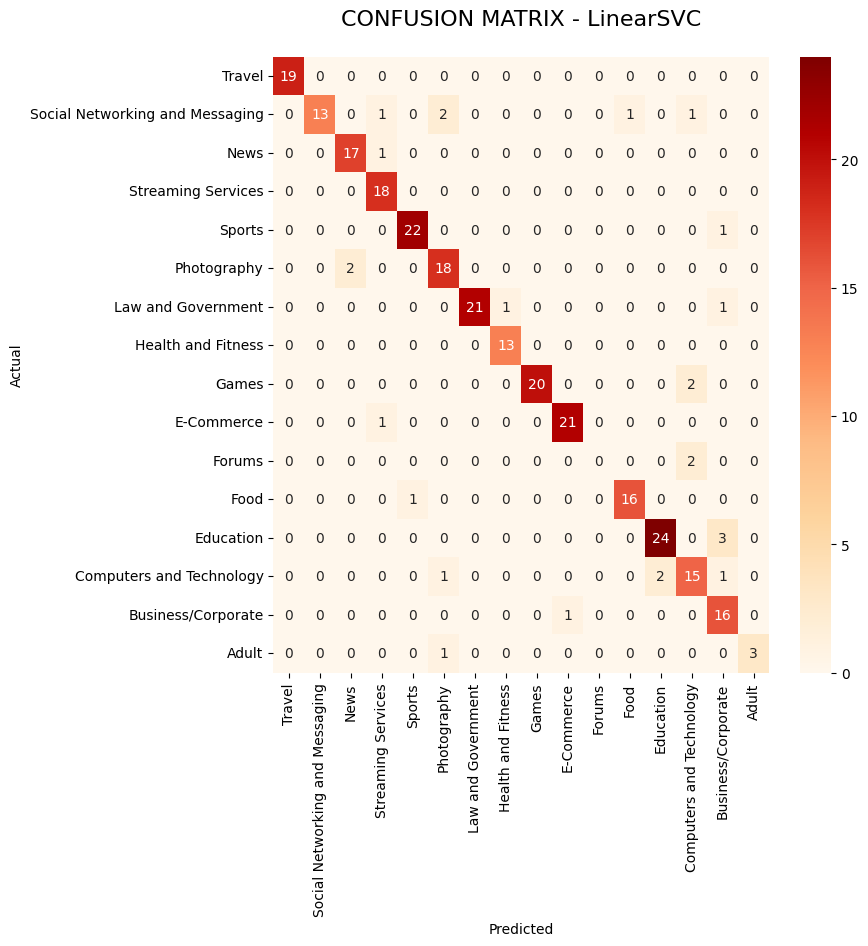

In [13]:
conf_mat = confusion_matrix(y_test, predicted,labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="OrRd", fmt='d',
            xticklabels=category_id_df.Category.values, 
            yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16)

In [31]:
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >0:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual],id_to_category[predicted],
                                                                   conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Category', 
                                                                'cleaned_website_text']])

'Photography' predicted as 'News' : 2 examples.


,Category,cleaned_website_text
451,Photography,pictures bbc news bbc news pictures news story...
558,Photography,welcome nedu wealth trend blog neduwealth news...


'Social Networking and Messaging' predicted as 'Streaming Services' : 1 examples.


,Category,cleaned_website_text
342,Social Networking and Messaging,facebook इन अप facebook वर इन आपण ओळखत faceboo...


'News' predicted as 'Streaming Services' : 1 examples.


,Category,cleaned_website_text
43,News,bandwidth limit exceed bandwidth limit exceed ...


'E-Commerce' predicted as 'Streaming Services' : 1 examples.


,Category,cleaned_website_text
1093,E-Commerce,amazon fresh skip main content hello select ad...


'Food' predicted as 'Sports' : 1 examples.


,Category,cleaned_website_text
941,Food,tío luchín cocina en vivo cocina en vivo prepa...


'Social Networking and Messaging' predicted as 'Photography' : 2 examples.


,Category,cleaned_website_text
346,Social Networking and Messaging,instagram create account log instagram simple ...


'Computers and Technology' predicted as 'Photography' : 1 examples.


,Category,cleaned_website_text


'Adult' predicted as 'Photography' : 1 examples.


,Category,cleaned_website_text


'Law and Government' predicted as 'Health and Fitness' : 1 examples.


,Category,cleaned_website_text
619,Law and Government,home prison ministry india prison ministry ind...


'Business/Corporate' predicted as 'E-Commerce' : 1 examples.


,Category,cleaned_website_text
1389,Business/Corporate,home page pet crafts exquisitely piece handcut...


'Social Networking and Messaging' predicted as 'Food' : 1 examples.


,Category,cleaned_website_text
350,Social Networking and Messaging,pinterest discover recipe home idea style insp...


'Computers and Technology' predicted as 'Education' : 2 examples.


,Category,cleaned_website_text
1192,Computers and Technology,neural network wikipedia neural network conten...
1252,Computers and Technology,quirksmode javascript javascript welcome javas...


'Social Networking and Messaging' predicted as 'Computers and Technology' : 1 examples.


,Category,cleaned_website_text
394,Social Networking and Messaging,xanga xanga xanga xanga xanga news learn theme...


'Games' predicted as 'Computers and Technology' : 2 examples.


,Category,cleaned_website_text
852,Games,clash arm welcome new clash arm web site find ...
823,Games,nylatenite gamer paradise page use frame brows...


'Forums' predicted as 'Computers and Technology' : 2 examples.


,Category,cleaned_website_text
869,Forums,stack overflow developer learn share build car...
875,Forums,ars technica openforum index page hardware twe...


'Sports' predicted as 'Business/Corporate' : 1 examples.


,Category,cleaned_website_text
261,Sports,sport job sport news sport feature sports mana...


'Law and Government' predicted as 'Business/Corporate' : 1 examples.


,Category,cleaned_website_text
669,Law and Government,british army homepage british army british arm...


'Education' predicted as 'Business/Corporate' : 3 examples.


,Category,cleaned_website_text
998,Education,aes electrophoresis society promote scientific...
1006,Education,home chemistry chemistry integrated independen...
993,Education,california bar exam prep attorneys reviews exe...


'Computers and Technology' predicted as 'Business/Corporate' : 1 examples.


,Category,cleaned_website_text
1263,Computers and Technology,come soon babylon come soon work hard finish d...
1245,Computers and Technology,webonthefly web content management custom deve...


In [33]:
model.fit(features, labels)

N = 4
for Category, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Category))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))

c:\Users\Richard Alejandro\Workspace\project-MLflow\Mlflow_project_Linkscribe\.venv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



==> 'Adult':
  * Top unigrams: bdsm, sex, erotic, bondage
  * Top bigrams: erotic story, sex toy, sex toys, live sex

==> 'Business/Corporate':
  * Top unigrams: investment, client, company, business
  * Top bigrams: real estate, audio visual, year experience, site work

==> 'Computers and Technology':
  * Top unigrams: software, file, web, windows
  * Top bigrams: source code, web hosting, come soon, easy use

==> 'E-Commerce':
  * Top unigrams: shipping, grocery, item, gift
  * Top bigrams: free shipping, gift card, grocery shopping, add cart

==> 'Education':
  * Top unigrams: university, science, student, chemistry
  * Top bigrams: open access, multiple choice, annual meeting, state university

==> 'Food':
  * Top unigrams: recipe, cake, restaurant, tasty
  * Top bigrams: order online, gluten free, home menu, breakfast lunch

==> 'Forums':
  * Top unigrams: forums, forum, answers, google
  * Top bigrams: share knowledge, mon dec, hour ago, post hour

==> 'Games':
  * Top unigrams:

In [6]:
X = df['cleaned_website_text'] # Collection of text
y = df['Category'] # Target or the labels we want to predict

In [7]:
X

0       official site good hotel accommodation big sav...
1       expedia hotel book sites like use vacation wor...
2       tripadvisor hotel book sites like previously d...
3       cheap flights search compare flights momondo f...
4       bot create free account create free account si...
                              ...                        
1403    old nude women porn mature granny sex horny ol...
1404    bdsm cams bdsm chat bondage cams free bdsm vid...
1405    porno dvd online european porn dvd cheap adult...
1406    anal dream house anal dream house anal dream h...
1407    world sex news daily sex news adult news eroti...
Name: cleaned_website_text, Length: 1408, dtype: object

In [8]:
y

0       Travel
1       Travel
2       Travel
3       Travel
4       Travel
         ...  
1403     Adult
1404     Adult
1405     Adult
1406     Adult
1407     Adult
Name: Category, Length: 1408, dtype: object

In [38]:
y1 = df['category_id']
y1

0        0
1        0
2        0
3        0
4        0
        ..
1403    15
1404    15
1405    15
1406    15
1407    15
Name: category_id, Length: 1408, dtype: int64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, df['category_id'], test_size=0.25, random_state = 0)

In [10]:
X_train

1062    hundred science fair projects student free sci...
195     shemaroo entertainment limited shemaroo entert...
657     voter registration find voter registration opt...
757     vet times website veterinary profession bring ...
70      luxury hotel soho london w1b hotel café royal ...
                              ...                        
763     everyday health trust medical information expe...
835     mopinball pinball machine information selling ...
1216    eurocrypt eurocrypt index page eurocrypt crypt...
559     latest business news technology news news yero...
684     idsa home new response idsa president barbara ...
Name: cleaned_website_text, Length: 1056, dtype: object

In [8]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1, 2), stop_words='english')

In [9]:
fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

In [10]:
m = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)
m1=CalibratedClassifierCV(estimator=m, cv="prefit").fit(tfidf_vectorizer_vectors, y_train)

c:\Users\Richard Alejandro\Workspace\project-MLflow\Mlflow_project_Linkscribe\.venv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [12]:
from bs4 import BeautifulSoup
import bs4 as bs4
from urllib.parse import urlparse
import requests
from collections import Counter
import pandas as pd
import os
class ScrapTool:
    def visit_url(self, website_url):
        '''
        Visit URL. Download the Content. Initialize the beautifulsoup object. Call parsing methods. Return Series object.
        '''
        #headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.71 Safari/537.36'}
        content = requests.get(website_url,timeout=60).content
        
        #lxml is apparently faster than other settings.
        soup = BeautifulSoup(content, "lxml")
        result = {
            "website_url": website_url,
            "website_name": self.get_website_name(website_url),
            "website_text": self.get_html_title_tag(soup)+self.get_html_meta_tags(soup)+self.get_html_heading_tags(soup)+
                                                               self.get_text_content(soup)
        }
        
        #Convert to Series object and return
        return pd.Series(result)
    
    def get_website_name(self,website_url):
        '''
        Example: returns "google" from "www.google.com"
        '''
        return "".join(urlparse(website_url).netloc.split(".")[-2])
    
    def get_html_title_tag(self,soup):
        '''Return the text content of <title> tag from a webpage'''
        return '. '.join(soup.title.contents)
    
    def get_html_meta_tags(self,soup):
        '''Returns the text content of <meta> tags related to keywords and description from a webpage'''
        tags = soup.find_all(lambda tag: (tag.name=="meta") & (tag.has_attr('name') & (tag.has_attr('content'))))
        content = [str(tag["content"]) for tag in tags if tag["name"] in ['keywords','description']]
        return ' '.join(content)
    
    def get_html_heading_tags(self,soup):
        '''returns the text content of heading tags. The assumption is that headings might contain relatively important text.'''
        tags = soup.find_all(["h1","h2","h3","h4","h5","h6"])
        content = [" ".join(tag.stripped_strings) for tag in tags]
        return ' '.join(content)
    
    def get_text_content(self,soup):
        '''returns the text content of the whole page with some exception to tags. See tags_to_ignore.'''
        tags_to_ignore = ['style', 'script', 'head', 'title', 'meta', '[document]',"h1","h2","h3","h4","h5","h6","noscript"]
        tags = soup.find_all(string=True)
        result = []
        for tag in tags:
            stripped_tag = tag.strip()
            if tag.parent.name not in tags_to_ignore\
                and isinstance(tag, bs4.element.Comment)==False\
                and not stripped_tag.isnumeric()\
                and len(stripped_tag)>0:
                result.append(stripped_tag)
        return ' '.join(result)

import spacy as sp
from collections import Counter
sp.prefer_gpu()
import en_core_web_sm
#anconda prompt ko run as adminstrator and copy paste this:python -m spacy download en
nlp = en_core_web_sm.load()
import re
def clean_text(doc):
    '''
    Clean the document. Remove pronouns, stopwords, lemmatize the words and lowercase them
    '''
    doc = nlp(doc)
    tokens = []
    exclusion_list = ["nan"]
    for token in doc:
        if token.is_stop or token.is_punct or token.text.isnumeric() or (token.text.isalnum()==False) or token.text in exclusion_list :
            continue
        token = str(token.lemma_.lower().strip())
        tokens.append(token)
    return " ".join(tokens) 

In [13]:
#website='https://leetcode.com/problemset/all/'
#website= 'https://www.kayak.com.co/'
website= 'https://www.twitch.tv/'
scrapTool = ScrapTool()
try:
    web=dict(scrapTool.visit_url(website))
    text=(clean_text(web['website_text']))
    t=fitted_vectorizer.transform([text])
    print(id_to_category[m1.predict(t)[0]])
    data=pd.DataFrame(m1.predict_proba(t)*100,columns=df['Category'].unique())
    data=data.T
    data.columns=['Probability']
    data.index.name='Category'
    a=data.sort_values(['Probability'],ascending=False)
    a['Probability']=a['Probability'].apply(lambda x:round(x,2))
except:
    print("Conection Timedout")



Streaming Services


In [21]:
a

,Probability
Category,
Streaming Services,75.81
Games,6.58
News,5.90
Business/Corporate,1.88
Photography,1.67
Education,1.31
Sports,1.17
Travel,0.99
Forums,0.78


In [19]:
with open('modeloweb.pkl', 'wb') as file:
    pickle.dump(m1, file)

In [ ]:

# Guardar el vectorizador en un archivo
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(fitted_vectorizer, file)